In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

org_data = pd.read_csv('../input/train.csv').drop(['Id'], axis=1)

In [2]:
org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [3]:
org_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


[Text(0.5, 0, 'Lost')]

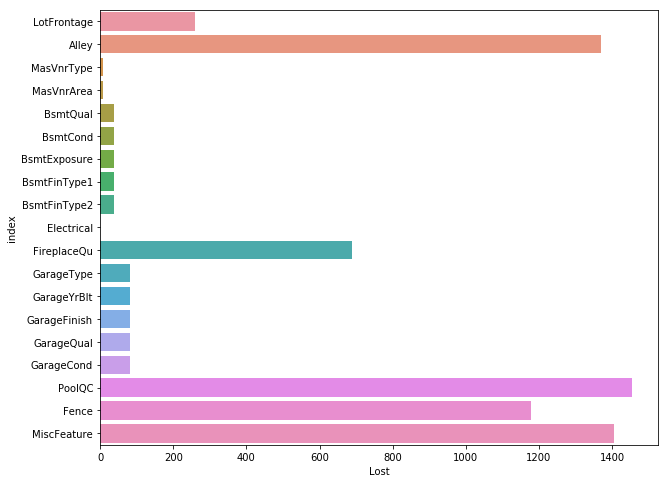

In [4]:
lost = org_data.count().copy(deep=True)
lost = 1460-lost[lost<1460]
lost_pd = lost.reset_index(name='count')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='count', y='index', data=lost_pd)
ax.set(xlabel='Lost')

In [5]:
data = org_data.copy(deep=True)

# EDA

In [ ]:
corr_mat = data.corr()
corr_mat['SalePrice'].sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(corr_mat, cmap='RdBu', center=0, square=True)

In [ ]:
plt.figure(figsize=(10,10))
corr_cols = corr_mat.nlargest(10, 'SalePrice')['SalePrice']
sns.heatmap(data[corr_cols.index].corr(), annot=True, square=True)

### SalePrice

In [ ]:
from scipy import stats
from scipy.stats import norm, skew

In [ ]:
sns.distplot(data['SalePrice'], fit=norm)
plt.ylabel('Frequency', fontsize=13)

plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

### *add log_SalePrice

In [ ]:
data['log_SalePrice'] = np.log(data['SalePrice'])
sns.distplot(data['log_SalePrice'], fit=norm)

plt.figure()
res = stats.probplot(data['log_SalePrice'], plot=plt)

### *HouseAge (not used)

In [ ]:
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
plt.figure(figsize=(20, 20))
sns.jointplot(x='HouseAge' ,y='YearBuilt', data=data)

## Analyze data

### MSSubClass (num -> cat)
meaning: 銷售的房屋類型 ex.幾間房、建築時間
- convert to **categorical** data

In [ ]:
var = 'MSSubClass'
new_var = 'cate_MSSubClass' 
# data[var].apply(str)
data[new_var] = data[var].astype(str)
print(data[new_var].value_counts().sort_index())
plt.figure(figsize=(15, 9))
sns.boxplot(x=new_var, y='log_SalePrice', data=data)

### MSZoning (cat)
meaning: 建築區域 ex.商業、密集/中/稀少住宅區、浮動


In [ ]:
msz = data['MSZoning'].copy()
msz.value_counts()
sns.boxplot(x='MSZoning', y='log_SalePrice', data=data)

### LotFrontage (num)
mean: 與道路接觸距離
- missed
    - median
- 偏斜 (skew = 2.5) 
    - **取log** (skew = -0.7)

In [ ]:
var = 'LotFrontage'
# sns.jointplot(x='LotFrontage', y='log_SalePrice', data=data)
ax = sns.kdeplot(data[var])
ax.set(xlabel='LotFrontage')
print('skew', data[var].skew())
print('kurt', data[var].kurt())
plt.show()

loged = np.log(data[var])
print('log_skew', loged.skew())
print('log_kurt', loged.kurt())
print('median', loged.median())
log_ax = sns.kdeplot(loged)
log_ax.set(xlabel='log LotFrontage')
plt.show()

mean = data[var].mean()
std = data[var].std()
z_score = (data[var]-mean)/std
print('std_skew', z_score.skew())
print('std_kurt', z_score.kurt())
print('median', z_score.median())
std_ax = sns.kdeplot(z_score)
std_ax.set(xlabel='z score LotFrontage')
# z_score

### Street & Alley(missed) (cat)
meaning: 與街道連接材質

In [ ]:
var = 'Street'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data)

In [ ]:
var = 'Alley'
data[var].value_counts()
sns.boxplot(x=var, y='log_SalePrice', data=data, order=['Pave', 'Grvl'])

### *drop | add RoadType(cat)
concern:
data unbalance

#### 4 type to try
0. drop Alley
1. RoadType = Alley filled with Street
2. Pave/ PaveGrvl/ Grvl
3. Pave/ both_Pave/ PaveGrvl/ Grvl

In [ ]:
df = data.copy(deep=True)
##### type 0 
print(df['Street'].value_counts())
sns.boxplot(x='Street', y='log_SalePrice', data=df)
plt.show()


####################

##### type 1
df['Alley_filled'] = df['Alley'].fillna(df['Street'])
print(df['Alley'].value_counts())
print(df['Alley_filled'].value_counts())
sns.boxplot(x='Alley_filled', y='log_SalePrice', data=df)
plt.show()

#### type 2
def fn_roadtype1(s, a):
    if s==a:
        return s
    elif s!=a:
        return s+a
    
df['RoadType1'] = df.apply(lambda row: fn_roadtype1(row['Street'], row['Alley_filled']), axis=1)
print(df['RoadType1'].value_counts())
sns.boxplot(x='RoadType1', y='log_SalePrice', data=df)
plt.show()

#### type 3
def isnan(x):
    return x!=x

def fn_roadtype2(s, a):
    if isnan(a):
        return s
    elif a==s:
        return 'both_'+s
    elif a!=s:
        return s+a

df['RoadType2'] = df.apply(lambda row: fn_roadtype2(row['Street'], row['Alley']), axis=1)
print(df['RoadType2'].value_counts())
sns.boxplot(x='RoadType2', y='log_SalePrice', data=df)

### LotShape (cat)

In [ ]:
var = 'LotShape'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data, order=['Reg', 'IR1', 'IR2', 'IR3'])

### LandContour(cat)

In [ ]:
var = 'LandContour'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data, order=['Lvl', 'Bnk', 'HLS', 'Low'])

### Utilities(cat)

In [ ]:
var = 'Utilities'
print(data[var].value_counts())

### LotConfig(cat)

In [ ]:
var = 'LotConfig'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data)

    ### LandSlope(cat)

In [ ]:
var = 'LandSlope'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data, order=['Gtl', 'Mod', 'Sev'])

### Neighborhood

In [ ]:
var = 'Neighborhood'
print(data[var].value_counts())
plt.figure(figsize=(26,12))
sns.boxplot(x=var, y='log_SalePrice', data=data, )

### Condition1 & 2

In [ ]:
var = 'Condition1'
print(data[var].value_counts())
plt.figure(figsize=(10,6))
sns.boxplot(x=var, y='log_SalePrice', data=data, order=['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe'])

In [ ]:
df = data.copy(deep=True)
def fn_condition(x):
    cond = x['Condition1']
    if cond in ('RRNn', 'RRAn', 'RRNe', 'RRAe'):
        return 'Near_Railroad'
    elif cond in ('PosN', 'PosA'):
        return 'Near_PositiveSite'
    else:
        return cond

df['Condition'] = df.apply(lambda x: fn_condition(x), axis=1)
print(df['Condition'].value_counts())
plt.figure(figsize=(10,6))
sns.boxplot(x='Condition', y='log_SalePrice', data=df)

In [ ]:
var = 'Condition2'
print(data[var].value_counts())
plt.figure(figsize=(10,6))
sns.boxplot(x=var, y='log_SalePrice', data=data, order=['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe'])

### BldgType

In [ ]:
var = 'BldgType'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data, order=['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'])

### HouseStyle

In [ ]:
var = 'HouseStyle'
print(data[var].value_counts())
plt.figure(figsize=(10, 12))
sns.boxplot(x=var, y='log_SalePrice', data=data, order=data[var].value_counts().sort_index().index)

In [ ]:
df = data.copy(deep=True)
def fn_apply(x):
    cond = x['HouseStyle']
    if cond in ('1Story', '1.5Fin'):
        return '1_fin'
    elif cond in ('2Story', '2.5Fin'):
        return '2_fin'
    elif cond in ('1.5Unf', '2.5Unf'):
        return 'unf'
    else:
        return cond

new_var = 'comb_HouseStyle'
df[new_var] = df.apply(lambda x: fn_apply(x), axis=1)
print(df[new_var].value_counts())
plt.figure(figsize=(6,10))
sns.boxplot(x=new_var, y='log_SalePrice', data=df)

### OverallQual

In [ ]:
var = 'OverallQual'
print(data[var].value_counts())
plt.figure(figsize=(12, 6))
sns.boxplot(x=var, y='log_SalePrice', data=data, order=data[var].value_counts().sort_index().index)

### OverallCond

In [ ]:
var = 'OverallCond'
print(data[var].value_counts())
plt.figure(figsize=(12, 6))
sns.boxplot(x=var, y='log_SalePrice', data=data, order=data[var].value_counts().sort_index().index)

### YearBuilt

In [ ]:
var = 'YearBuilt'
# print(data[var].value_counts())
plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
# sns.jointplot(x=var, y='log_SalePrice', data=data)
sns.boxplot(x=var, y='log_SalePrice', data=data)

### YearRemodAdd

In [ ]:
var = 'YearRemodAdd'
# print(data[var].value_counts())
plt.figure(figsize=(12, 6))
sns.jointplot(x=var, y='log_SalePrice', data=data, kind='reg')

### BsmtExposure

In [ ]:
var = 'BsmtExposure'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data, \
            order=['Gd', 'Av', 'Mn', 'No', 'NA'])

### BsmtFinType1

In [ ]:
var = 'BsmtFinType1'
print(data[var].value_counts())
plt.figure(figsize=(8,12))
sns.boxplot(x=var, y='log_SalePrice', data=data, \
           order=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'])

### BsmtFinSF1

In [ ]:
var = 'BsmtFinSF1'
print(data[var].value_counts()[0])
plt.figure(figsize=(8,12))
sns.jointplot(x=var, y='log_SalePrice', data=data, kind='reg')

In [ ]:
# data[['BsmtFinSF1', 'BsmtFinType1']]
gp = data.groupby('BsmtFinSF1')
gp.get_group(0)['BsmtFinType1'].value_counts(dropna=False)

### BsmtFinType2

In [ ]:
var = 'BsmtFinType2'
print(data[var].value_counts(dropna=False))
plt.figure(figsize=(8,12))
sns.boxplot(x=var, y='log_SalePrice', data=data, \
           order=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'])

### BsmtFinSF2

In [ ]:
var = 'BsmtFinSF2'
print(data[var].value_counts()[0])
plt.figure(figsize=(8,12))
sns.jointplot(x=var, y='log_SalePrice', data=data, kind='reg')

In [ ]:
# data[['BsmtFinSF2', 'BsmtFinType2']]
gp = data.groupby('BsmtFinSF1')
gp.get_group(0)['BsmtFinSF2'].value_counts(dropna=False)

### Electrical

In [ ]:
var = 'Electrical'
print(data[var].value_counts())
plt.figure(figsize=(8,12))
sns.boxplot(x=var, y='log_SalePrice', data=data)

### GarageFinish

In [ ]:
var = 'GarageFinish'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data)

### PavedDrive

In [ ]:
var = 'PavedDrive'
print(data[var].value_counts())
sns.boxplot(x=var, y='log_SalePrice', data=data)

### Fence

In [ ]:
var = 'Fence'
print(data[var].value_counts(dropna=False))
sns.boxplot(x=var, y='log_SalePrice', data=data)

### MoSold

In [ ]:
var = 'MoSold'
# print(data[var].value_counts().sort_index())
plt.figure(figsize=(12, 8))
# sns.barplot(x=var, y='SalePrice', data=data, order=np.sort(data[var].unique()))
sns.boxplot(x=var, y='log_SalePrice', data=data, order=np.sort(data[var].unique()))

### YrSold

In [ ]:
var = 'YrSold'
# print(data[var].value_counts().sort_index())
plt.figure(figsize=(6, 8))
sns.boxplot(x=var, y='log_SalePrice', data=data, order=np.sort(data[var].unique()))

### SaleType

In [ ]:
var = 'SaleType'
print(data[var].value_counts(dropna=False))
plt.figure(figsize=(15, 8))
sns.boxplot(x=var, y='log_SalePrice', data=data)

### SaleCondition

In [ ]:
var = 'SaleCondition'
print(data[var].value_counts(dropna=False))
# plt.figure(figsize=(15, 8))
sns.boxplot(x=var, y='log_SalePrice', data=data)

# Data Processing

In [70]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

In [8]:
def fill_na(X):

    filled_X = X.copy()

    # LotFrontage
    """
    Fill in missing values by the median LotFrontage of the neighborhood.
    
    https://i.stack.imgur.com/sgCn1.jpg
    
    df.groupby('col_1')['col_2'] -> looks like split section
    df.groupby('col_1')['col_2'].transform(lambda k: ...) -> k get the split_1, 2, 3
    
    """
    filled_X.groupby('Neighborhood')['LotFrontage'].transform(lambda k: k.fillna(k.median()))
#     filled_X['LotFrontage'].fillna(value=filled_X['LotFrontage'].median(), inplace=True)
    
    # Alley
    filled_X['Alley'].fillna(value='NA', inplace=True)
    
    # MasVnrType
    filled_X['MasVnrType'].fillna(value='NA', inplace=True)
    # MasVnrArea
    filled_X['MasVnrArea'].fillna(value=0, inplace=True)
    
    # BsmtQual
    filled_X['BsmtQual'].fillna(value="NA", inplace=True)
    # BsmtCond
    filled_X['BsmtCond'].fillna(value="NA", inplace=True)
    # BsmtExposure
    filled_X["BsmtExposure"].fillna(value="NA", inplace=True)
    # BsmtFinType1
    filled_X["BsmtFinType1"].fillna(value="NA", inplace=True)
    # BsmtFinType2
    filled_X["BsmtFinType2"].fillna(value="NA", inplace=True)
    
    # Electrical
    filled_X["Electrical"].fillna("SBrkr", inplace=True)
    
    # FireplaceQu
    filled_X["FireplaceQu"].fillna(value="NA", inplace=True)
    
    # GargaeYrBlt
    filled_index = filled_X[filled_X["GarageYrBlt"].isna()].index
    YrBlt = filled_X.loc[filled_index, "YearBuilt"]
    filled_X.loc[filled_index, "GarageYrBlt"] = YrBlt
    
    # GarageType
    filled_X["GarageType"].fillna(value="NA", inplace=True)
    # GarageFinish
    filled_X["GarageFinish"].fillna(value="NA", inplace=True)
    # GarageQual
    filled_X["GarageQual"].fillna(value="NA", inplace=True)
    # GarageCond
    filled_X["GarageCond"].fillna(value="NA", inplace=True)
    
    # PoolQC
    filled_X["PoolQC"].fillna(value="NA", inplace=True)
    
    # Fence
    filled_X["Fence"].fillna(value="NA", inplace=True)
    
    # MiscFeature
    filled_X["MiscFeature"].fillna(value="NA", inplace=True)
    
    return filled_X

In [10]:
def process_data(X, y, num_imputer=None, scaler=None, cat_imputer=None, onehoter=None):
    
    # fill missing value
    X = fill_na(X)
    
    ###### Transform
    
    # num -> cat
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)
    X['YrSold'] = X['YrSold'].astype(str)
#     X['YearBuilt'] = X['YearBuilt'].astype(str)
    
    # cat -> ord  
    cat_to_ord_cols_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', \
                         'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    cat_to_ord_dict_1 = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
    for col in cat_to_ord_cols_1:
        X[col] = X[col].map(cat_to_ord_dict_1, )
    
    X['BsmtExposure'] = X['BsmtExposure'].map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0})
    X['CentralAir'] = X['CentralAir'].map({'Y':1, 'N':0})
    X['GarageFinish'] = X['GarageFinish'].map({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0})
    X['PavedDrive'] = X['PavedDrive'].map({'Y':1, 'P':0.5, 'N':0})
    X['BsmtFinType1'] = X['BsmtFinType1'].map({'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':2, 'LwQ':1, 'Unf':0})
    X['BsmtFinType2'] = X['BsmtFinType2'].map({'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':2, 'LwQ':1, 'Unf':0})
    X['Electrical'] = X['Electrical'].map({'SBrkr':4, 'FuseA':3, 'FuseF':2, 'FuseP':1, 'Mix':0})
    X['Fence'] = X['Fence'].map({'GdPrv':4, 'MnPrv':3, 'FdWo':2, 'MnWw':1, 'NA':0})
    
    # add new feature
    X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
    
    ######

    # split num/cat data
    num_X = X.select_dtypes(include=np.number)
    cat_X = X.select_dtypes(exclude=np.number)
#     print(num_X.columns, cat_X.columns, sep='\n')
    
    # impute num data
    if num_imputer==None:
        num_imputer = SimpleImputer(strategy='median')
        imputed_num_X = num_imputer.fit_transform(num_X)
        imputed_num_X = pd.DataFrame(imputed_num_X, index=num_X.index, columns=num_X.columns)
    else:
        imputed_num_X = num_imputer.transform(num_X)
        imputed_num_X = pd.DataFrame(imputed_num_X, index=num_X.index, columns=num_X.columns)
    
    
    imputed_num_X += 1
    # scale num data
    if scaler==None:
        scaler = make_pipeline(PowerTransformer(method='box-cox'),  RobustScaler())
        scaled_num_X = scaler.fit_transform(imputed_num_X)
        scaled_num_X = pd.DataFrame(scaled_num_X, index=num_X.index, columns=num_X.columns)
    else:
        scaled_num_X = scaler.transform(imputed_num_X)
        scaled_num_X = pd.DataFrame(scaled_num_X, index=num_X.index, columns=num_X.columns)
    
    
    # impute cat data
    if cat_imputer==None:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        imputed_cat_X = cat_imputer.fit_transform(cat_X)
    else:
        imputed_cat_X = cat_imputer.transform(cat_X)   
    
    # onehotencode cat data
    if onehoter==None:
        onehoter = OneHotEncoder(sparse=False, handle_unknown='ignore')
        onehot_cat_X = pd.DataFrame(onehoter.fit_transform(imputed_cat_X), index=cat_X.index)
    else:
        onehot_cat_X = pd.DataFrame(onehoter.transform(imputed_cat_X), index=cat_X.index)

    ######
    
    fin_num_X = scaled_num_X
    fin_cat_X = onehot_cat_X
    
    processed_X = pd.concat([fin_num_X, fin_cat_X], axis=1, sort=False)
    processed_X.info()
    
    ######
    
    if y is not None:
        processed_y = np.log(y)
    else:
        processed_y = None
    
    return processed_X, processed_y, num_imputer, scaler, cat_imputer, onehoter

In [76]:
data = org_data.copy(deep=True)
data = shuffle(data, random_state=1).reset_index(drop=True)

In [77]:
X, y, num_imputer, scaler, cat_imputer, onehoter = process_data( X=data.drop(['SalePrice'], axis=1), y=data['SalePrice'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 263 entries, LotFrontage to 210
dtypes: float64(263)
memory usage: 2.9 MB


In [78]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,...,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210
0,1.022628,2.089891,1.857977,3.459714,-1.112221,-0.031000,0.000000,1.0,2.609961,-1.0,0.000000,1.000000,-0.65228,-0.830482,0.0,0.0,0.834771,0.229025,0.0,0.000000,0.000000,0.724238,1.067851,7.561215,1.996947,0.0,0.0,0.000000,1.0,0.982885,0.0,1.814501,2.207798,0.471717,0.181971,0.380454,-1.0,1.124166,1.390160,10.068313,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.094643,-0.120664,-2.234654,-2.461362,-0.436445,-0.916470,0.000000,0.0,0.000000,-1.0,0.000000,1.587293,0.00000,-0.413194,0.0,0.0,-0.082672,-1.119841,-1.0,-4.054383,-3.573805,-1.854948,0.000000,0.000000,-2.453158,1.0,0.0,-2.130773,0.0,-2.023495,0.0,0.000000,-1.154914,-1.000000,-0.675386,-0.400356,-1.0,-1.000000,-0.731209,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.792842,0.124961,0.960326,0.000000,0.815679,0.424104,1.080385,1.0,0.000000,0.0,3.562967,1.587293,-0.65228,-0.830482,0.0,0.0,1.307862,1.124119,0.0,0.000000,0.000000,0.820543,0.000000,0.000000,0.179555,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.467028,0.000000,0.324614,0.778575,0.0,1.124166,1.334874,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.493461,-0.990510,0.000000,0.000000,-0.760647,-0.916470,0.000000,0.0,0.000000,-1.0,0.000000,0.000000,-0.65228,-0.830482,0.0,0.0,0.669043,-0.063643,-1.0,-4.054383,0.000000,-0.215105,0.000000,0.000000,-0.871638,0.0,0.0,-1.000000,0.0,-1.000000,0.0,0.000000,-0.532972,0.000000,0.324614,-0.850535,-1.0,-1.000000,-1.327181,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.358668,0.117243,0.489216,0.000000,0.645411,0.199481,0.000000,0.0,0.000000,0.0,0.000000,0.000000,-0.65228,-0.830482,0.0,0.0,-0.167467,-1.359722,0.0,0.000000,0.000000,-0.756277,0.989865,0.000000,-0.051878,0.0,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.883140,0.000000,0.181971,0.586166,0.0,0.000000,-0.332602,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Build Model

In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold
import keras

In [14]:
n_cv = 5
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=n_cv, scoring='neg_mean_squared_error'))
    return rmse

### DNN

In [79]:
dnn_X = np.array(X)
dnn_y = np.array(y)

train_X, test_X, train_y, test_y = train_test_split(dnn_X, dnn_y)

In [80]:
def get_model():
    dnn = keras.Sequential()
    dnn.add(keras.layers.Dense(units=100, activation='relu'))
    dnn.add(keras.layers.Dense(100, activation='relu'))
    dnn.add(keras.layers.Dense(1))
    dnn.compile(loss='mean_squared_error', optimizer='adam') #, metrics='mean_squared_error'
    return dnn

In [81]:
kf = KFold(n_splits=5, random_state=1)
score = np.array([])

batch_size = 16
epochs = 20

fold_cnt = 1
for train_id, test_id in kf.split(dnn_X, dnn_y):
    print("\nFold {}\n".format(fold_cnt))
    fold_cnt += 1
    
    dnn = get_model()
    dnn.fit(dnn_X[train_id], dnn_y[train_id], batch_size=batch_size, epochs=epochs, validation_data=(dnn_X[test_id], dnn_y[test_id]))
    score = np.append(score, (dnn.evaluate(dnn_X[test_id], dnn_y[test_id])))

print('DNN error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))


Fold 1

Train on 1168 samples, validate on 292 samples
Epoch 1/20
1168/1168 [==============================] - 6s 5ms/step - loss: 27.9578 - val_loss: 0.8934
Epoch 2/20
1168/1168 [==============================] - 0s 339us/step - loss: 0.5323 - val_loss: 0.3957
Epoch 3/20
1168/1168 [==============================] - 0s 334us/step - loss: 0.2616 - val_loss: 0.2367
Epoch 4/20
1168/1168 [==============================] - 0s 336us/step - loss: 0.1595 - val_loss: 0.1755
Epoch 5/20
1168/1168 [==============================] - 0s 334us/step - loss: 0.1072 - val_loss: 0.1497
Epoch 6/20
1168/1168 [==============================] - 0s 342us/step - loss: 0.0767 - val_loss: 0.1208
Epoch 7/20
1168/1168 [==============================] - 0s 338us/step - loss: 0.0593 - val_loss: 0.0917
Epoch 8/20
1168/1168 [==============================] - 0s 335us/step - loss: 0.0457 - val_loss: 0.0764
Epoch 9/20
1168/1168 [==============================] - 0s 334us/step - loss: 0.0358 - val_loss: 0.0666
Epoch 10/

1168/1168 [==============================] - 0s 338us/step - loss: 0.0143 - val_loss: 0.0555
Epoch 16/20
1168/1168 [==============================] - 0s 340us/step - loss: 0.0131 - val_loss: 0.0489
Epoch 17/20
1168/1168 [==============================] - 0s 338us/step - loss: 0.0115 - val_loss: 0.0446
Epoch 18/20
1168/1168 [==============================] - 0s 335us/step - loss: 0.0106 - val_loss: 0.0497
Epoch 19/20
1168/1168 [==============================] - 0s 337us/step - loss: 0.0106 - val_loss: 0.0432
Epoch 20/20
292/292 [==============================] - 0s 96us/step

Fold 5

Train on 1168 samples, validate on 292 samples
Epoch 1/20
1168/1168 [==============================] - 6s 5ms/step - loss: 28.3585 - val_loss: 0.8520
Epoch 2/20
1168/1168 [==============================] - 0s 337us/step - loss: 0.5121 - val_loss: 0.3770
Epoch 3/20
1168/1168 [==============================] - 0s 347us/step - loss: 0.2259 - val_loss: 0.2322
Epoch 4/20
1168/1168 [==============================

In [82]:
xgb = XGBRegressor(learning_rate=.2, max_depth=3, n_estimators=100 , random_state=1)

score = rmse_cv(xgb, X, y)

print('Xgboost error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Xgboost error: 0.1309 (0.0073)


In [83]:
gb = GradientBoostingRegressor(learning_rate=.1, n_estimators=100, random_state=1)

score = rmse_cv(gb, X, y)

print('Gradient Boosting error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Gradient Boosting error: 0.1272 (0.0059)


In [84]:
ridge = RidgeCV()

score = rmse_cv(ridge, X, y)

print('Ridge error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Ridge error: 0.1267 (0.0177)


In [85]:
lasso = Lasso(alpha=0.0005, random_state=1)

score = rmse_cv(lasso, X, y)

print('Lasso error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Lasso error: 0.1239 (0.0177)


In [86]:
##### l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
elastic = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=1)

score = rmse_cv(elastic, X, y)

print('ElasticNet error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

ElasticNet error: 0.1238 (0.0178)


In [87]:
svm = SVR()

score = rmse_cv(svm, X, y)

print('SVM error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

SVM error: 0.1241 (0.0087)


### Averaging model

In [90]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, model_dict):
        self.model_dict = model_dict
    
    def fit(self, X, y):
        for name, model in self.model_dict.items():
            if name=='dnn':
                model.fit(np.array(X), np.array(y), batch_size=16, epochs=20, verbose=0)
            else:
                model.fit(X, y)
            
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for name, model in self.model_dict.items()])
        return np.mean(predictions, axis=1)

In [91]:
dnn = get_model()
averaged_models = AveragingModels({'xgb':xgb, 'gb':gb, 'ridge':ridge, 'lasso':lasso, 'elastic':elastic, 'svm':svm, 'dnn':dnn})

score = rmse_cv(averaged_models, X, y)

print('averged models error: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

averged models error: 0.1228 (0.0150)


# Build Final model

In [92]:
train_data = org_data.copy()
train_data = shuffle(train_data).reset_index(drop=True)

org_test_data = pd.read_csv('../input/test.csv')
test_data = org_test_data.drop(['Id'], axis=1).copy()

In [93]:
train_X, train_y, num_imputer, scaler, cat_imputer, onehoter = process_data(train_data.drop(['SalePrice'], axis=1), train_data['SalePrice'])
print()
test_X, _, _, _, _, _ = process_data(test_data, None, num_imputer, scaler, cat_imputer, onehoter )

/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 263 entries, LotFrontage to 210
dtypes: float64(263)
memory usage: 2.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 263 entries, LotFrontage to 210
dtypes: float64(263)
memory usage: 2.9 MB


In [94]:
def rmse_error(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

In [96]:
dnn = get_model()
final_model = AveragingModels({'xgb':xgb, 'gb':gb, 'ridge':ridge, 'lasso':lasso, 'elastic':elastic, 'svm':svm, 'dnn':dnn})
final_model.fit(train_X, train_y)
pred = final_model.predict(train_X)
print(rmse_error(pred, train_y))

final_y_hat = final_model.predict(test_X)
inverse_y_hat = np.exp(final_y_hat)

0.08525338927605669


In [97]:
final_y_hat

array([11.68906567, 11.9808956 , 12.13321962, ..., 12.0056518 ,
       11.69247825, 12.3437908 ])

In [98]:
inverse_y_hat

array([119260.52509547, 159674.97197222, 185947.49382434, ...,
       163677.25272661, 119668.20656686, 229530.40927933])

In [99]:
# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.

output = pd.DataFrame({'Id': org_test_data.Id,
                      'SalePrice': inverse_y_hat})
output.to_csv('submission.csv', index=False)